# Importing all the Required packages that we'll use first
#### Change to be just a regressor, no more randomness at all

In [118]:
import random
import pickle
import time
import pathlib

import pandas as pd
import numpy as np
import rasterio as rio
import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import matplotlib.font_manager
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
# from sklearn.neural_network import MLPClassifier # Maybe we'll use this instead
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from yellowbrick.regressor import PredictionError
from sklearn.metrics import r2_score
# from sklearn.metrics import precision_score, recall_score, make_scorer

# import cartopy

coreLimit = int(336*(.45/2)) # Parallel Processing # 336 Total Cores Available
# Predicting on biomass_mg

## Creating a Data Handling Class for ease of passing data around. 

In [119]:
class Data():
    def __init__(self, X=None, Y=None):
        if X != None:
            self.__x = X
        else:
            self.__x = 0
        if Y != None:
            self.__y = Y
        else:
            self.__y = 0

    def __del__(self):
        del self.__x, self.__y

    def set_x(self, X):
        self.__x = X

    def set_y(self, Y):
        self.__y = Y
        
    def get_x(self):
        return self.__x

    def get_y(self):
        return self.__y
# end Data

## Reading Data into Memory

                  id   NDVI_Jun13   NDMI_Jun13    PRISM_ppt   PRISM_tave  \
count    8974.000000  8974.000000  8974.000000  8974.000000  8974.000000   
mean   150377.090372  3718.534999  2573.091246  1844.852920     9.865800   
std     86870.722503  1008.902601  1038.802994   799.249613     1.604252   
min        37.000000   526.493000 -1539.970000   264.963000     4.600000   
25%     76159.500000  3010.157500  2120.062500  1323.510000     9.119900   
50%    150147.000000  3767.335000  2821.760000  1818.985000    10.070000   
75%    225756.000000  4486.300000  3302.072500  2340.010000    10.850000   
max    299930.000000  6254.720000  4616.590000  5057.150000    15.420000   

       Biomass (mg/ha)  Carbon (mg/ha)    Stock (%)      Age2018   Height2018  \
count      8974.000000     8974.000000  8974.000000  8974.000000  8974.000000   
mean        207.343214       52.449871    56.094156    64.437761    68.350370   
std          80.446479       33.962805    14.186152    38.423668    22.2

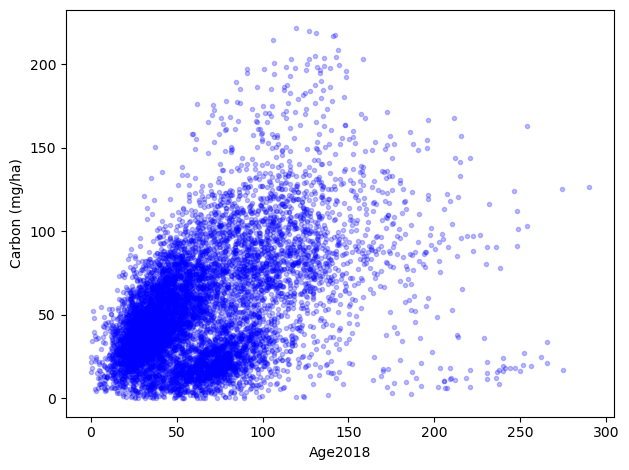

In [120]:
USFS_forest_file = 'data/csv_files/USFS_forest_biomass_mg_ha_Privategt50%_CAORWA_Unburned_random_10K.csv'
USFS_forest = pd.read_csv(USFS_forest_file)

# Removing invalid data (i.e., -9999.0)
count = 0
for i in USFS_forest:
    USFS_forest = USFS_forest[USFS_forest[i] != -9999.0] # Recreating dataset without invalid rows
    if i == 'Age2018' or i == 'biomass_mg' or i == 'Stock2018':
        USFS_forest = USFS_forest[USFS_forest[i] != 0]
USFS_forest['Carbon2018'] = USFS_forest['Carbon2018']*11.11
USFS_forest = USFS_forest.rename(columns={'Carbon2018': 'Carbon (mg/ha)', 'biomass_mg': 'Biomass (mg/ha)', 'Stock2018': 'Stock (%)'})
print(USFS_forest.describe()) # Post-Removal

# Displaying all the Data
plot1 = plt.scatter(USFS_forest['Age2018'], USFS_forest['Carbon (mg/ha)'], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
plt.ylabel('Carbon (mg/ha)')
plt.xlabel('Age2018')
# plt.title('')
# plt.legend(handles=[plot1], loc='best',)
plt.tight_layout()
plt.show()

## Splitting the Data

In [121]:
x_train, x_test , y_train, y_test= train_test_split(
    USFS_forest[[
        'NDVI_Jun13', 
        'NDMI_Jun13', 
        'PRISM_ppt', 
        'PRISM_tave', 
        # 'Carbon2018', # Possible Y # Uses Mg C per 30x30 Pixel (Conversion factor: 11.11 for Mg/ha)
        # 'Stock2018',  # Possible Y
        'Age2018', 
        # 'Height2018', # Possible Y
    ]], 
    USFS_forest['Carbon (mg/ha)'],
    train_size=0.8,
    shuffle=True, # Default: True
)
model_data_2 = Data() # A container for our data
model_data_2.set_x([x_train, x_test])
model_data_2.set_y([y_train, y_test])

## Creating a new Model

In [122]:
poly = PolynomialFeatures(degree=2, include_bias=False)
pipe = Pipeline([
    ("scale", QuantileTransformer()), # Try without
    ("model", SVR()),
    # ("polynomial", PolynomialFeatures()),
    # ("model", LinearRegression()),
])    
# param_distributions={
#     'scale__n_quantiles':554, 
#     'model__n_jobs':coreLimit,
#     'verbose':True,
# }
# model = pipe.set_params(**param_distributions)
# print(model.get_params())
model = RandomizedSearchCV(
    estimator=pipe,
    param_distributions={
        'scale__n_quantiles':[i for i in range (10, 1000)], 
        'scale__copy': [True, False], 
        # 'scale__ignore_implicit_zeros': [True, False], 
        'scale__output_distribution': ['uniform', 'normal'], 
        'model__kernel': ['linear'], #, 'precomputed'
        'model__degree': [2],
        'model__gamma': ['scale', 'auto']+[i/100 for i in range(0,100)],
        'model__C': [i/100 for i in range(50,150)],
        'model__epsilon': [i/1000 for i in range(50,150)],
        'model__shrinking': [True, False],


        
        # 'polynomial__degree': [1, 2],
        # 'polynomial__include_bias': [False],
        # # 'scale__subsample': [i for i in range (10, 10000)],
        # 'model__copy_X': [True, False], 
        # 'model__fit_intercept': [True, False], 
        # 'model__positive': [True, False],
        
        # 'scale__random_state': [i for i in range(1, 1000)],
        # 'model__n_estimators': [i for i in range(100, 1000)], 
        # 'model__max_depth': [i for i in range(1, 2000)],
        # # 'model__random_state': [i for i in range (1, 1000)],
        # 'model__max_features':['log2', 'sqrt',]+[i for i in range(1, 1000)],
        # 'model__min_samples_leaf':[i for i in range (1, 1000)],
        # 'model__min_samples_split':[i for i in range (2, 1000)],
        # 'verbose':[True],
    },
    # refit=True,
    cv=10, # Cross Validations
    n_jobs=coreLimit, #252, # Parallel Processing # 336 Total Cores Available
    verbose=1,
    n_iter=10000, # Number of Iterations (Default: 10)
)
# print(model.get_params())
model
# print(model_2.get_params())

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('scale', QuantileTransformer()),
                                             ('model', SVR())]),
                   n_iter=10000, n_jobs=75,
                   param_distributions={'model__C': [0.5, 0.51, 0.52, 0.53,
                                                     0.54, 0.55, 0.56, 0.57,
                                                     0.58, 0.59, 0.6, 0.61,
                                                     0.62, 0.63, 0.64, 0.65,
                                                     0.66, 0.67, 0.68, 0.69,
                                                     0.7, 0.71, 0.72, 0.73,
                                                     0.74, 0.75, 0.76, 0.77,
                                                     0.78, 0.79, ...],
                                        'model__degree': [2],
                                        'model__epsilon': [0.0...
                                                         0.09, 0.1, 0.11, 0.12,
                                                         0.13, 0.14, 0.15, 0.16,
                                                         0.17, 0.18, 0.19, 0.2,
                                                         0.21, 0.22, 0.23, 0.24,
                                                         0.25, 0.26, 0.27, ...],
                                        'model__kernel': ['linear'],
                                        'model__shrinking': [True, False],
                                        'scale__copy': [True, False],
                                        'scale__n_quantiles': [10, 11, 12, 13,
                                                               14, 15, 16, 17,
                                                               18, 19, 20, 21,
                                                               22, 23, 24, 25,
                                                               26, 27, 28, 29,
                                                               30, 31, 32, 33,
                                                               34, 35, 36, 37,
                                                               38, 39, ...],
                                        'scale__output_distribution': ['uniform',
                                                                       'normal']},
                   verbose=1)

## Fitting the Model to the Data

In [123]:
timeStart = time.time()
stock_rf = model.fit(model_data_2.get_x()[0], model_data_2.get_y()[0])
print('Fit completed in '+str(round((time.time()-timeStart)//60))+' minutes and '+str(round((time.time()-timeStart)%60, 1))+' seconds.')
results = pd.DataFrame(stock_rf.cv_results_) # Saving the cross validation results for later

Fitting 10 folds for each of 10000 candidates, totalling 100000 fits
Fit completed in 39 minutes and 22.7 seconds.


## Predicting and Generating Graphs

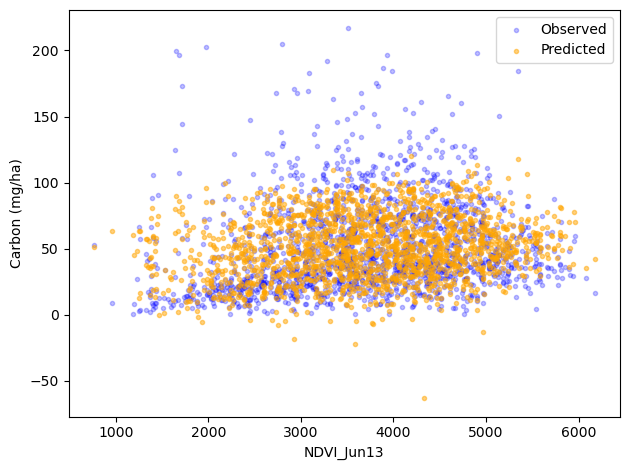

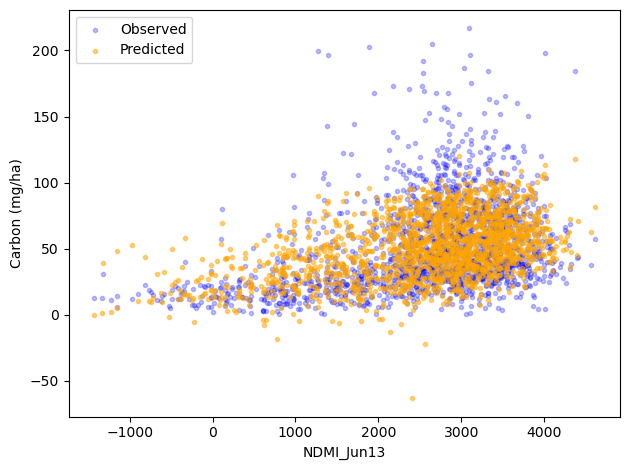

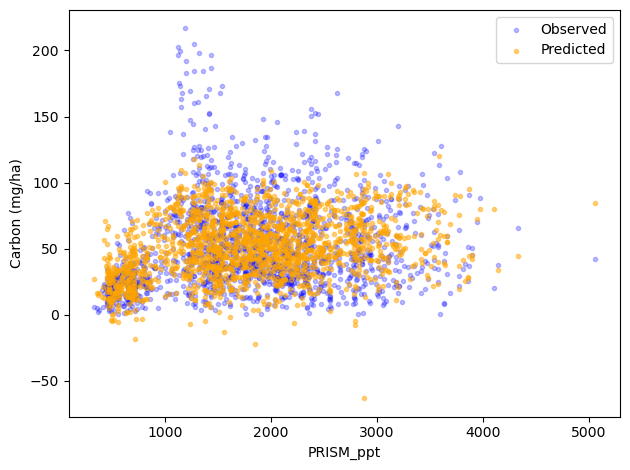

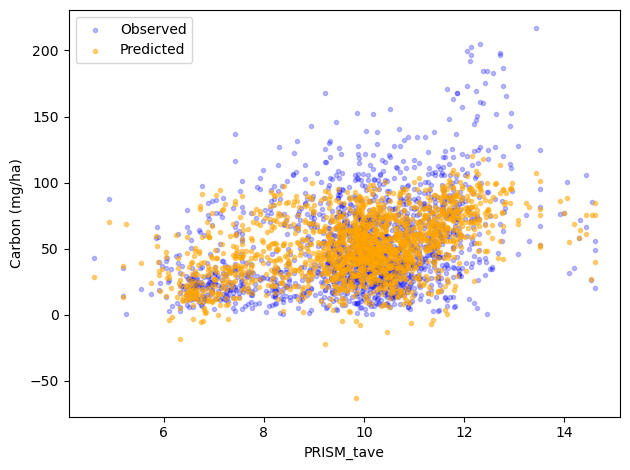

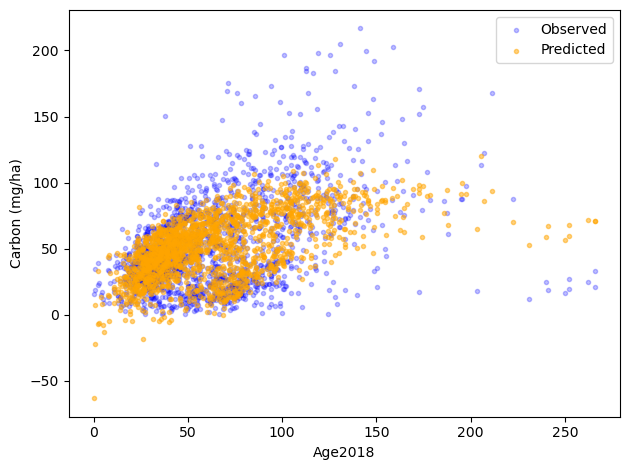

In [124]:
pred = model.predict(model_data_2.get_x()[1])

for k, v in enumerate(model_data_2.get_x()[1]):
    plot1 = plt.scatter(model_data_2.get_x()[1][v], model_data_2.get_y()[1], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
    plot2 = plt.scatter(model_data_2.get_x()[1][v], pred, label = 'Predicted', color = 'orange', marker='.', alpha=0.5)
    plt.ylabel('Carbon (mg/ha)')
    plt.xlabel(v)
    plt.legend(handles=[plot1, plot2], loc='best',)
    plt.tight_layout()
    plt.show()

## Visualizing Errors

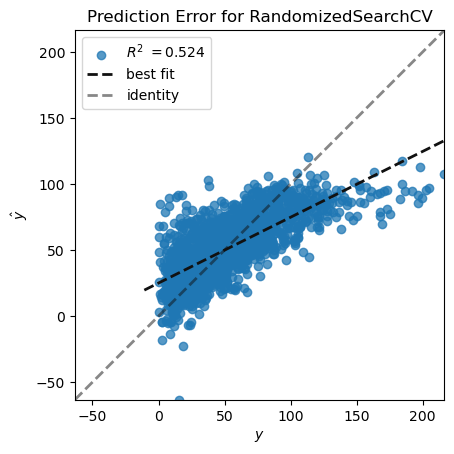

0.5240070988359649


In [125]:
visualizer = PredictionError(stock_rf)
visualizer.score(model_data_2.get_x()[1],  model_data_2.get_y()[1])
visualizer.poof()
f_list = [model_data_2.get_x()[0].columns]
print(r2_score(model_data_2.get_y()[1], pred))

## Displaying Importance Values, a graph of the Highest Importance vs Target, and the Best Estimator Parameters from the RandomizedSearchCV

In [126]:
print('Coefficients :', stock_rf.best_estimator_.named_steps['model'].coef_)
print('Intercept: ', stock_rf.best_estimator_.named_steps['model'].intercept_)

equation = 'y = '
for i, v in importance.items():
    equation = equation+'+ '+str(i)+'*'+str(v)+' '
equation = equation+'+ '+str(stock_rf.best_estimator_.named_steps['model'].intercept_)
print(equation)

??stock_rf.best_estimator_.named_steps['model']

Coefficients : [[-7.07100301 16.44817434  6.64864862 10.14428407 21.09804246]]
Intercept:  [51.37354261]


NameError: name 'importance' is not defined

In [ ]:
# ??stock_rf.named_steps
# print(stock_rf.named_steps['model'].coef_)
# print(stock_rf)
print(stock_rf.best_estimator_.named_steps['model'].coef_)#coef_)
print(stock_rf.best_estimator_.feature_names_in_)
# importance = pd.Series(
#     # stock_rf.feature_importances_,
#     stock_rf.best_estimator_.named_steps['model'].coef_,
#     # stock_rf.feature_names_in_,
#     # stock_rf.best_estimator_._final_estimator.feature_importances_,
#     stock_rf.best_estimator_.feature_names_in_,
# ).sort_values(ascending=False)
# print('Feature Coefficients:')
# print(importance, '\n')

# # Displaying all the Data
# print(importance.index[0])
# plot1 = plt.scatter(USFS_forest[importance.index[0]], USFS_forest['Carbon2018'], label = 'Observed', color = 'blue', marker='.', alpha=0.25)
# plt.ylabel('Carbon2018')
# plt.xlabel(importance.index[0])
# plt.title(importance.index[0]+' vs Carbon2018')
# # plt.legend(handles=[plot1], loc='best',)
# plt.tight_layout()
# plt.show()

print('Best Estimator & Parameters:')
print('Score: ', round(r2_score(model_data_2.get_y()[1], pred), 3))
print(stock_rf.best_params_, '\n')
print(results.loc[stock_rf.best_index_])
# print(len(carbon_results))
# print(carbon_rf.best_estimator_._final_estimator.getParams())
# print(carbon_results.loc[carbon_rf.best_index_])

Score:  0.504
{'scale__output_distribution': 'normal', 'scale__n_quantiles': 13, 'scale__copy': True, 'model__positive': False, 'model__fit_intercept': True, 'model__copy_X': False} 
Score:  0.508
{'scale__output_distribution': 'normal', 'scale__n_quantiles': 14, 'scale__copy': True, 'model__positive': True, 'model__fit_intercept': True, 'model__copy_X': False}


Score:  0.54
{'scale__output_distribution': 'normal', 'scale__n_quantiles': 16, 'scale__copy': False, 'model__positive': False, 'model__fit_intercept': True, 'model__copy_X': False} 

Score:  0.514
{'scale__output_distribution': 'normal', 'scale__n_quantiles': 14, 'scale__copy': False, 'model__positive': True, 'model__fit_intercept': True, 'model__copy_X': False}  